In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd


In [2]:
#Helper funciton to build 1 mer feature
def readFASTA(filename):
    seqs = []
    with open(filename, "r") as fin:
        for line in fin:
            if line[0] == ">":
                continue
            seqs.append(line.strip())
    return seqs
def get1mer(seqs):
    bp = {"A": np.array([0,0,0,1]),
          "C": np.array([0,0,1,0]),
          "G": np.array([0,1,0,0]),
          "T": np.array([1,0,0,0])}
    featureMatrix = np.zeros((len(seqs), len(seqs[0])*4))
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            featureMatrix[i, j*4:j*4+4] = bp[seqs[i][j]]
    return featureMatrix

## 1. Read data

In [3]:
seqs = readFASTA("Mad.fa")
feature1mer = get1mer(seqs)

df = pd.DataFrame(data = feature1mer)
df["affinity"] = pd.read_csv("Mad.s", sep = "\t", header = None)[1]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,affinity
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.763428
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.903412
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,10.208874
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.273974
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,8.325185


In [4]:
#Alternative way to encode sequence by using Pandas get_dummies()
#Designed to change categorical columns to numerical columns for later use
df_alt = pd.read_csv("Mad.s", sep = "\t", header = None)
df_seq = df_alt[0].str.split("", expand = True)
df_seq = pd.get_dummies(df_seq)
df_alt.drop(0, 1, inplace = True)
df_alt = pd.concat((df_seq, df_alt), axis = 1)
df_alt.head()

,0_,1_A,1_C,1_G,1_T,2_A,2_C,2_G,2_T,3_A,...,35_A,35_C,35_G,35_T,36_A,36_C,36_G,36_T,37_,1
0,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,1,8.763428
1,1,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,1,7.903412
2,1,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,10.208874
3,1,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,8.273974
4,1,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,8.325185


# 2. Seperate data into training and test

In [5]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('affinity')
test_labels = test_features.pop('affinity')

# 3. Build model

## 3.1 Linear model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
]) #y = w*x_1 + w*x_2 + ... + b

In [8]:
model.predict(train_features[:10])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[-0.92430675],
       [-1.1742994 ],
       [ 0.4420812 ],
       [ 0.17921719],
       [-0.22704643],
       [ 0.07611528],
       [-0.30847305],
       [-0.80052346],
       [-0.4481498 ],
       [-0.47758996]], dtype=float32)

In [9]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error') #mean_squared_error
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 145       
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [10]:
%%time
history = model.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 16.9 s, sys: 3.59 s, total: 20.5 s
Wall time: 12 s


In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.265295,0.283704,95
96,0.266073,0.282846,96
97,0.265849,0.285788,97
98,0.265408,0.282392,98
99,0.266042,0.285857,99


In [12]:
import matplotlib.pyplot as plt
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

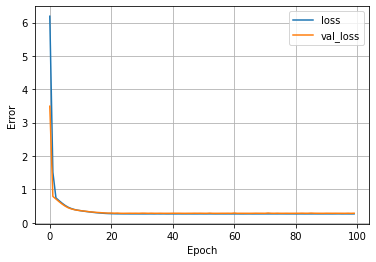

In [13]:
plot_loss(history)


In [14]:
import sklearn.metrics
test_result = model.evaluate(
    test_features, test_labels, verbose=0)
print("MAE:", test_result)
y_pred = model.predict(test_features)
print("R2 score:", sklearn.metrics.r2_score(test_labels, y_pred))

MAE: 0.2837846875190735
R2 score: 0.7012501276611351


## 3.2 Deep Neural network (DNN) model

In [15]:
# Build a DNN model
def build_and_compile_model():
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                9280      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 13,505
Tra

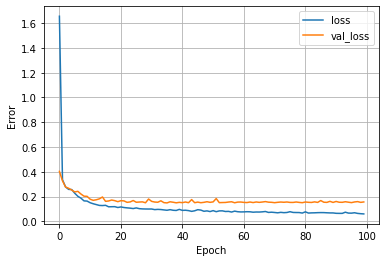

In [16]:
dnnmodel = build_and_compile_model()
history = dnnmodel.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)
dnnmodel.summary()
plot_loss(history)

In [17]:
test_result = dnnmodel.evaluate(
    test_features, test_labels, verbose=0)
print("MAE:", test_result)
y_pred = dnnmodel.predict(test_features)
print("R2 score:", sklearn.metrics.r2_score(test_labels, y_pred))

MAE: 0.1503545194864273
R2 score: 0.9416273955947309


## 3.3 Convolutional Neural network (CNN) model

In [18]:
#CNN model
def build_and_compile_model_cnn():
    model = tf.keras.Sequential([
      tf.keras.layers.Reshape((-1, 4)), 
      tf.keras.layers.Conv1D(64, 3, activation = 'relu'),
      tf.keras.layers.AveragePooling1D(2),
      tf.keras.layers.Conv1D(128, 3, activation = 'relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 36, 4)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 34, 64)            832       
_________________________________________________________________
average_pooling1d_1 (Average (None, 17, 64)            0         
________________________

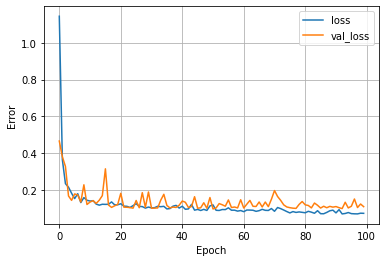

In [20]:
cnnmodel = build_and_compile_model_cnn()
history = cnnmodel.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)
cnnmodel.summary()
plot_loss(history)

In [21]:
test_result = cnnmodel.evaluate(
    test_features, test_labels, verbose=0)
print("MAE:", test_result)
y_pred = cnnmodel.predict(test_features)
print("R2 score:", sklearn.metrics.r2_score(test_labels, y_pred))

MAE: 0.11829524487257004
R2 score: 0.9619420138400021
